In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn.feature_selection import RFE
from scipy import stats

from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import numpy as np

from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

In [21]:
scaler = StandardScaler()

# Replace these two dataframes with the paths to where the base dataset and test dataset is located
df = pd.read_csv(r'C:\Users\Daniel\Downloads\DiseaseX_Detection_Dataset.csv') #Path needs to be changed
test = pd.read_csv(r"C:\Users\Daniel\Downloads\DiseaseX_Detection_Test.csv") #Path needs to be changed
newtest = pd.read_csv(r"C:\Users\Daniel\Downloads\DiseaseX_detection_Test_Perturbed.csv") #Path needs to be changed



# Define a function to remove outliers using Z-score
def remove_outliers_zscore(dataframe, threshold=1.96):
    z_scores = np.abs(stats.zscore(dataframe))
    outliers = (z_scores > threshold).any(axis=1)
    dataframe_no_outliers = dataframe[~outliers]
    return dataframe_no_outliers

# Set the threshold for Z-score (adjustable)
zscore_threshold = 1.96

# Apply the function to remove outliers for each column
for column in df.columns:
    newdf = remove_outliers_zscore(df, threshold=zscore_threshold)

# Splitting the Data into training and testing
x = newdf.loc[:,newdf.columns!= 'Response']


y = newdf.Response


# Standardize the features in 'x' while keeping it as a DataFrame
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Similarly, standardize the features in 'test' while keeping it as a DataFrame
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)
newtest_scaled = pd.DataFrame(scaler.transform(newtest), columns=newtest.columns)

# Use Recursive Feature Elimination with cross-validation
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=55)  # Choose the desired number of features
x_rfe = rfe.fit_transform(x_scaled, y)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_rfe, y, test_size=0.2, random_state=0)

# Access the boolean mask of selected features
selected_features = np.array(x.columns)[rfe.support_]

In [22]:
# Define the logistic regression model with class weights
model = LogisticRegression(class_weight={0: 1, 1: 2}, random_state=42, C = 100, max_iter = 100, solver = 'liblinear')

# Train the model on the training data
model.fit(x_train, y_train)

# model = logreg.fit(x_train_downsampled, y_train_downsampled)
y_pred=model.predict(x_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Precision:', metrics.precision_score(y_test, y_pred))
print('Recall:', metrics.recall_score(y_test, y_pred))


# Print the selected features
print("Selected Features:", selected_features)



# Get the indices of the top 3 coefficients by absolute value (excluding index 0 which is the constant)
top_indices = np.argsort(np.abs(model.coef_[0, 1:]))[::-1][:3]

# Get the top 3 coefficients and their corresponding features
top_coefficients = model.coef_[0, 1:][top_indices]
top_features = selected_features[top_indices]

# Display the top 3 coefficients and their corresponding features
for i, (feature, coefficient) in enumerate(zip(top_features, top_coefficients), 1):
    print(f"Top {i}: Coefficient {coefficient} for feature '{feature}'.")
    
# Set up a 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation and get the accuracy scores
accuracy_scores = cross_val_score(model, x_scaled, y, cv=cv, scoring='accuracy')

# Print the accuracy scores for each fold
print("Accuracy scores for each fold:", accuracy_scores)

# Print the mean accuracy across all folds
print("Mean accuracy:", np.mean(accuracy_scores))

cnf_matrix

Accuracy: 0.7428671247234191
Precision: 0.6812549960031974
Recall: 0.8475882645450025
Selected Features: ['X1' 'X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'X9' 'X10' 'X13' 'X14' 'X15'
 'X16' 'X17' 'X18' 'X19' 'X20' 'X23' 'X24' 'X27' 'X30' 'X31' 'X32' 'X36'
 'X37' 'X38' 'X39' 'X41' 'X44' 'X49' 'X53' 'X55' 'X56' 'X57' 'X58' 'X59'
 'X61' 'X63' 'X64' 'X65' 'X69' 'X71' 'X73' 'X74' 'X76' 'X77' 'X78' 'X79'
 'X81' 'X83' 'X85' 'X87' 'X88' 'X90']
Top 1: Coefficient 0.9233048935712209 for feature 'X1'.
Top 2: Coefficient 0.3688891061695808 for feature 'X3'.
Top 3: Coefficient -0.28082759514282996 for feature 'X20'.
Accuracy scores for each fold: [0.75104797 0.7424313  0.74941779 0.74027487 0.74539949 0.7498253
 0.7423713  0.74772886 0.75052411 0.74959236]
Mean accuracy: 0.7468613347993088


array([[2970, 1595],
       [ 613, 3409]], dtype=int64)

In [23]:

predictions=model.predict(newtest_scaled[selected_features])

# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(data={'Predictions': predictions}, index=newtest.index)


# Calculate the sum of predictions that are 1s and 0s
sum_of_ones = predictions_df['Predictions'].sum()
sum_of_zeros = len(predictions_df) - sum_of_ones

# Display the results
print(f"Sum of predictions that are 1s: {sum_of_ones}")
print(f"Sum of predictions that are 0s: {sum_of_zeros}")

predictions_df


Sum of predictions that are 1s: 4742
Sum of predictions that are 0s: 1900


C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  


,Predictions
0,1
1,1
2,1
3,1
4,1
...,...
6637,1
6638,0
6639,0
6640,1


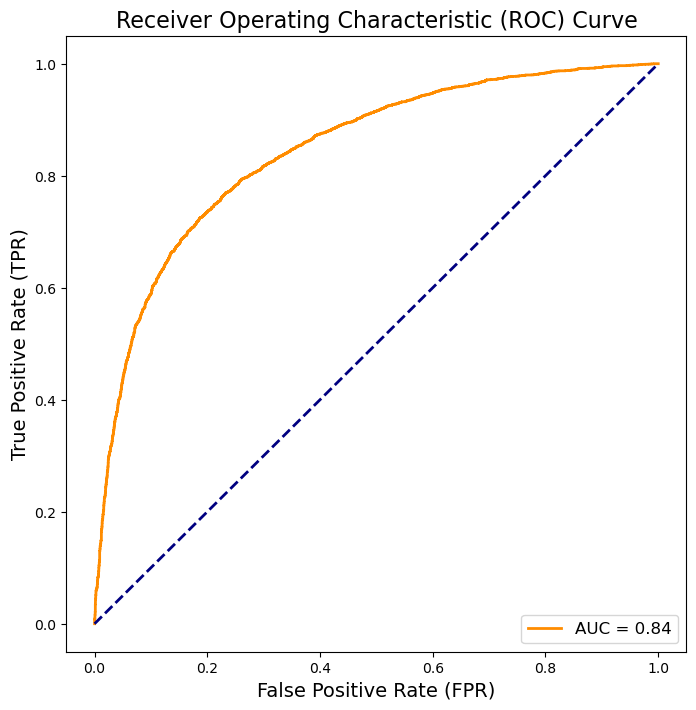

In [13]:
# Get the predicted probabilities for the positive class
y_scores = model.predict_proba(x_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.show()


In [ ]:
clf1 = RandomForestClassifier(n_estimators = 200, max_depth= None, bootstrap = True, random_state=0).fit(x_train, y_train)
y_pred_RF = clf1.predict(x_test)

In [ ]:
## Confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_RF)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred_RF))
cnf_matrix

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()

model.fit(x_train, y_train)

y_hat = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(confusion_matrix(y_test, y_hat))

from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_hat)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_hat))

In [4]:
from sklearn.svm import SVC
SVM_model1 = SVC(kernel='rbf', gamma='scale', C = 100)
SVM_model1.fit(x_train, y_train)

SVM_model2 = SVC(kernel='rbf', gamma='scale', C = 50)
SVM_model2.fit(x_train, y_train)

SVM_model3 = SVC(kernel='rbf', gamma='scale', C = 1)
SVM_model3.fit(x_train, y_train)


SVC(C=1)

In [5]:
models = [SVM_model1, SVM_model2, SVM_model3]



from sklearn.metrics import accuracy_score, classification_report

for model in models:
    
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))


Accuracy: 0.748922790264353
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      4565
           1       0.73      0.73      0.73      4022

    accuracy                           0.75      8587
   macro avg       0.75      0.75      0.75      8587
weighted avg       0.75      0.75      0.75      8587

Accuracy: 0.7573075579364155
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4565
           1       0.74      0.74      0.74      4022

    accuracy                           0.76      8587
   macro avg       0.76      0.76      0.76      8587
weighted avg       0.76      0.76      0.76      8587

Accuracy: 0.788051706067311
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      4565
           1       0.80      0.74      0.76      4022

    accuracy                           0.79      8587
   macro avg       0.79      0.78      0.79

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(svm_classifier, x_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

In [ ]:
# Get predicted probabilities for ROC curve
y_proba = svm_classifier.predict_proba(x_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')http://localhost:8888/notebooks/Documents/Deliverable3.ipynb#
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(confusion_matrix(y_test, y_hat))

In [ ]:
y_hat = svm_classifier.predict(test_scaled[selected_features])

In [ ]:
# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(data={'Predictions': y_hat}, index=test.index)


# Calculate the sum of predictions that are 1s and 0s
sum_of_ones = predictions_df['Predictions'].sum()
sum_of_zeros = len(predictions_df) - sum_of_ones

# Display the results
print(f"Sum of predictions that are 1s: {sum_of_ones}")
print(f"Sum of predictions that are 0s: {sum_of_zeros}")

predictions_df

In [24]:
csv_file_path = r"C:\Users\Daniel\Downloads\y_hat(2).csv"

# Export the DataFrame to a CSV file
predictions_df.to_csv(csv_file_path, index=False)

print(f"DataFrame exported to {csv_file_path}")

DataFrame exported to C:\Users\Daniel\Downloads\y_hat(2).csv


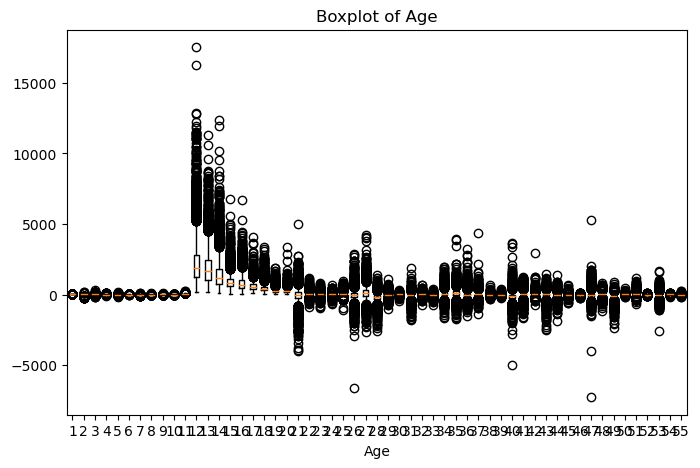

In [34]:
# Plotting a boxplot for a specific column (e.g., 'Age')
plt.figure(figsize=(8, 5))  # Set the figure size

# Create the boxplot
plt.boxplot(newtest[selected_features], vert=True)  # Change 'Age' to the column you want to plot

# Adding labels and title
plt.xlabel('Age')
plt.title('Boxplot of Age')

# Show the plot
plt.show()

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a pipeline with StandardScaler and SGDClassifier with Huber loss
model = make_pipeline(StandardScaler(), SGDClassifier(loss='huber', random_state=42))

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7290089670432048


In [16]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

SVM_model4 = SVC(kernel='rbf', gamma='scale')
SVM_model4.fit(x_train, y_train)
print('done')

y_pred = SVM_model4.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


done
Accuracy: 0.788051706067311
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      4565
           1       0.80      0.74      0.76      4022

    accuracy                           0.79      8587
   macro avg       0.79      0.78      0.79      8587
weighted avg       0.79      0.79      0.79      8587



In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the logistic regression model with class weights
model = LogisticRegression(class_weight={0: 1, 1: 2}, random_state=42)

# Define the hyperparameters grid for tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers for optimization
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Train the grid search on the training data
grid_search.fit(x_train, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the test data
y_pred = best_model.predict(x_test)

# Print classification report to evaluate performance
print(classification_report(y_test, y_pred))

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      4565
           1       0.68      0.85      0.76      4022

    accuracy                           0.74      8587
   macro avg       0.76      0.75      0.74      8587
weighted avg       0.76      0.74      0.74      8587

Best Hyperparameters: {'C': 100, 'max_iter': 100, 'solver': 'liblinear'}


In [21]:
y_hat = model.predict(newtest_scaled[selected_features])

# Create a new DataFrame for predictions
predictions_df = pd.DataFrame(data={'Predictions': y_hat}, index=newtest_scaled.index)


# Calculate the sum of predictions that are 1s and 0s
sum_of_ones = predictions_df['Predictions'].sum()
sum_of_zeros = len(predictions_df) - sum_of_ones

# Display the results
print(f"Sum of predictions that are 1s: {sum_of_ones}")
print(f"Sum of predictions that are 0s: {sum_of_zeros}")

predictions_df

Sum of predictions that are 1s: 4100
Sum of predictions that are 0s: 2542


C:\Users\Daniel\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Predictions
0,0
1,1
2,1
3,1
4,1
...,...
6637,1
6638,1
6639,0
6640,1


  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.9.0
    Uninstalling imbalanced-learn-0.9.0:
      Successfully uninstalled imbalanced-learn-0.9.0
Note: you may need to restart the kernel to use updated packages.
